In [3]:
%env OMP_NUM_THREADS=8

env: OMP_NUM_THREADS=8


In [4]:
%pylab inline
import time
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import theano
theano.config.floatX = 'float32'
import theano.tensor as T

Populating the interactive namespace from numpy and matplotlib


In [5]:
from itertools import *
import pickle
#from hep_ml.reweight import BinsReweighter
import numpy as np
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split

In [6]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../utils')
import dem
import classes

In [61]:
%pylab inline
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

class xgbClf:
    def __init__(self,name = 'default_z'):
        self.xgb_clf = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.05, max_depth = 5, min_child_weight = 2)
        self.name = name
    def fit(self, X_train, y_train):
        print "start fitting"
        self.xgb_clf.fit(dem.rev_(X_train), y_train)
        self.write(self.name)
        print "fitting succeed"
    def count_score(self, X_val, y_val):
        valid_answ = self.xgb_clf.predict_proba(dem.rev_(X_val))
        self.valid_answ = valid_answ
        print "On val:", roc_auc_score(y_val, valid_answ[:,1])
        score = roc_auc_score(y_val, valid_answ[:,1])
        fpr_, tpr_, thresholds_ = roc_curve(y_val, valid_answ[:,1])
        plt.plot(fpr_, tpr_, label="Roc-Curve")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        str_for_plot = 'Roc-Curve for ' + self.name + ": "+ str(round(score,4))
        plt.title(str_for_plot)
        
    def predict_prob(self,test_sample):
        return self.xgb_clf.predict_proba(dem.rev_(test_sample))
    def write (self, file_name):
        import pickle
        print "storing classifier in file", file_name,"...",
        pickle.dump(self.xgb_clf, open ('class/'+file_name, "wb"))
        print " ...done"

Populating the interactive namespace from numpy and matplotlib


## Separate fitting full and boundary square ##

** Stack datasets :  x_tr, x_val, y_tr, y_val, area_tr, area_val**

In [14]:
simple0, inner0, outer0 = dem.preprocess3('../../../obt_data/inner_outer/Pi0Area0.pcl', '../../../obt_data/inner_outer/PhArea0.pcl')

area list len: 42632 12277 0
area list len: 63530 18879 0


In [22]:
def make_clf(elem, name):
    clf_= xgbClf(name)
    clf_.fit(elem[0], elem[2])
    clf_.count_score(elem[1], elem[3])
    return clf_

In [19]:
simple1, inner1, outer1 = dem.preprocess3('../../../obt_data/inner_outer/Pi0Area1.pcl', '../../../obt_data/inner_outer/PhArea1.pcl')

area list len: 21921 7665 3774
area list len: 39216 13960 10397


In [21]:
simple2, inner2, outer2 = dem.preprocess3('../../../obt_data/inner_outer/Pi0Area2.pcl', '../../../obt_data/inner_outer/PhArea2.pcl')

area list len: 29895 0 3617
area list len: 45499 0 9546


## 0 area ##

start fitting
storing classifier in file 0_simpl ...  ...done
fitting succeed
On val: 0.958620892345


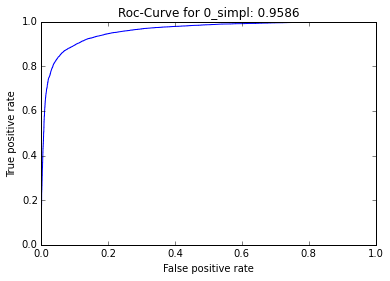

In [62]:
clf0_simple = make_clf(simple0, '0_simpl')

start fitting
storing classifier in file 0_inner ...  ...done
fitting succeed
On val: 0.915141255879


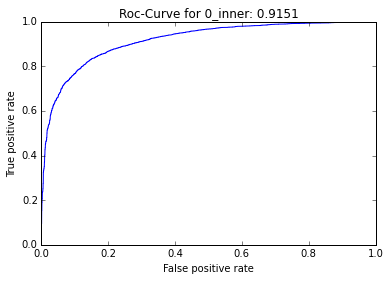

In [63]:
clf0_inner= make_clf(inner0, '0_inner')

In [36]:
clf0_outer = xgbClf()

## 1 area ##

start fitting
storing classifier in file 1_simpl ...  ...done
fitting succeed
On val: 0.970124804178


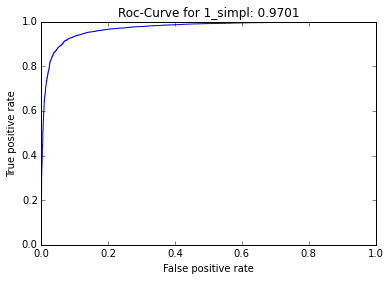

In [64]:
clf1_simple=make_clf(simple1, '1_simpl')

start fitting
storing classifier in file 1_inner ...  ...done
fitting succeed
On val: 0.935824837007


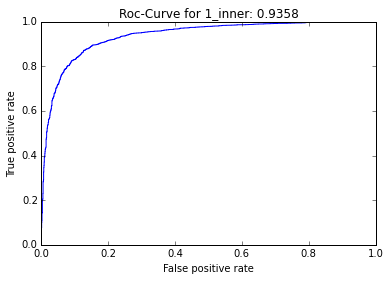

In [65]:
clf1_inner=make_clf(inner1, '1_inner')

start fitting
storing classifier in file 1_outer ...  ...done
fitting succeed
On val: 0.949296635174


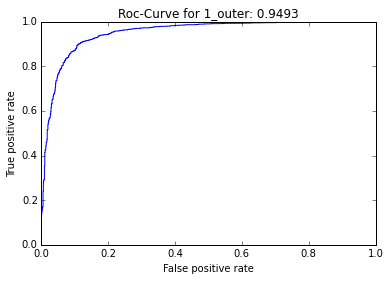

In [66]:
clf1_outer=make_clf(outer1, '1_outer')

## 2 area ##

start fitting
storing classifier in file 2_simpl ...  ...done
fitting succeed
On val: 0.95996415362


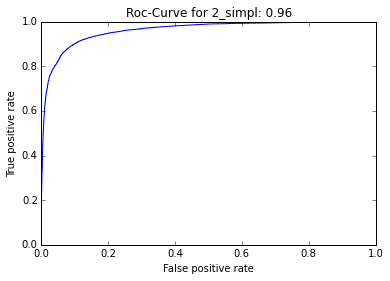

In [67]:
clf2_simple=make_clf(simple2, '2_simpl')

start fitting
storing classifier in file 2_outer ...  ...done
fitting succeed
On val: 0.960871540869


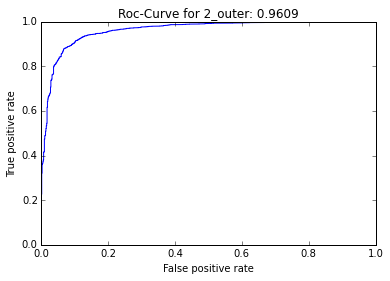

In [68]:
clf2_outer=make_clf(outer2, '2_outer')

In [43]:
clf2_inner = xgbClf()

## Common classifier ##

In [44]:
classifiers = {0:{0:clf0_simple, 1:clf0_inner, 2:clf0_outer}, 1:{0:clf1_simple, 1:clf1_inner, 2:clf1_outer}, 2:{0:clf2_simple, 1:clf2_inner, 2:clf2_outer}}

In [550]:
map(len,[X_val0, X_val1, X_val2, X_val_rec0, X_val_rec, X_val_rec2])

[26541, 15285, 18849, 14741, 10993, 3291]

In [551]:
map(len,[y_val0, y_val1, y_val2, y_val_rec0, y_val_rec, y_val_rec2])

[26541, 15285, 18849, 14741, 10993, 3291]

In [47]:
for elem in [simple0[1], simple1[1], simple2[1], inner0[1], inner1[1], inner2[1], outer0[1], outer1[1], outer2[1]]:
    print elem.shape

(26541, 2, 5, 5)
(15285, 2, 5, 5)
(18849, 2, 5, 5)
(7789, 2, 5, 5)
(5407, 2, 5, 5)
(0,)
(0,)
(3543, 2, 5, 5)
(3291, 2, 5, 5)


In [48]:
X_common_val = np.concatenate([simple0[1], simple1[1], simple2[1], inner0[1], inner1[1], outer1[1], outer2[1]], axis = 0)
Y_common_val = np.concatenate([simple0[3], simple1[3], simple2[3], inner0[3], inner1[3], outer1[3], outer2[3]], axis = 0)
Common_clf = np.concatenate([simple0[5], simple1[5], simple2[5], inner0[5], inner1[5], outer1[5], outer2[5]], axis = 0)
shuffle_ind = np.arange(len(X_common_val))
np.random.shuffle(shuffle_ind)
X_common_val = X_common_val[shuffle_ind]
Y_common_val = Y_common_val[shuffle_ind]
Common_clf = Common_clf[shuffle_ind]

In [51]:
def common_prediction(X_common_val, Common_clf):
    answ = []
    print 'common prediction'
    for (X_val, clf) in (zip(X_common_val, Common_clf)):
        try:
            clf_partial = classifiers[clf[0]][clf[1]]
            answ.append(clf_partial.xgb_clf.predict_proba(X_val.ravel().reshape((1,50))))
            if len(answ)%5000 == 0:
                print len(answ)
        except:
            print "clf", clf
            break
    return answ


In [52]:
answ_common = common_prediction(X_common_val, Common_clf)

common prediction
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000


On val: 0.95589153987


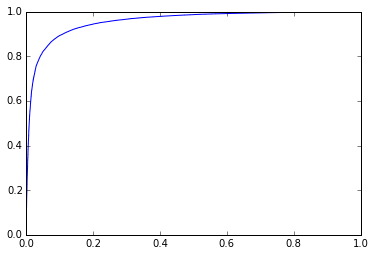

In [53]:
predict_answ = np.array(answ_common).reshape((len(answ_common), 2))[:,1]
print "On val:", roc_auc_score(Y_common_val, predict_answ)
fpr_, tpr_, thresholds_ = roc_curve(Y_common_val,predict_answ)
plt.plot(fpr_, tpr_, label="Roc-Curve")